In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
from tensorflow.keras import layers
print(tf.__version__)
print(tf.test.is_gpu_available())

import matplotlib.pyplot as plt
import numpy as np

2.0.0


In /home/suzi/anaconda3/envs/tf2/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/suzi/anaconda3/envs/tf2/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/suzi/anaconda3/envs/tf2/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/suzi/anaconda3/envs/tf2/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/suzi/anaconda3/envs/tf2

True


# config

In [2]:
data_path = '/media/suzi/Seagate Expansion Drive/cough_task_for_job/data/melspectrograms/melspectrograms'
train_path = data_path + '/train/*/*'
test_path = data_path + '/test/*/*'
val_path = data_path + '/validation/*/*'

class_names = ['sick', 'not_sick']
img_height = 480#227
img_width = 640#227
batch_size = 4
train_samples = 1434 + 2282
steps_per_epoch = train_samples // batch_size
steps_per_epoch

929

# get dataset

In [3]:
def decode_str_tensor(tensor):
    return bytes.decode(tensor.numpy())

def stats(t):
    s = 'mean:'
    s += str(t.mean())
    s += ' max:'
    s += str(t.max())
    s += ' min:'
    s += str(t.min())
    s += ' median:'
    s += str(np.median(t))
    s += ' std:'
    s += str(t.std())
    s += ' shape:'
    s += str(t.shape)
    s += ' dtype:'
    s += str(t.dtype)
    print(s)

In [4]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    one_hot = tf.cast(one_hot, tf.int64)
    # Integer encode the label
    return tf.argmax(one_hot)
# get_label('/media/suzi/Seagate Expansion Drive/cough_task_for_job/data/continuous_wavelet_transform/continuous_wavelet_transform/train/sick/audioset_0CroKP1sYVw_10_15.jpg')

In [5]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    # resize the image to the desired size
    img = tf.image.resize(img, [img_height, img_width])        
    return img, label
# img, label = process_path('/media/suzi/Seagate Expansion Drive/cough_task_for_job/data/continuous_wavelet_transform/continuous_wavelet_transform/train/sick/audioset_0CroKP1sYVw_10_15.jpg')
# stats(img.numpy())

In [6]:
def augumation(img, label):
    if tf.random.uniform(()) > 0.33:
        rand = tf.cast(tf.random.uniform(())*img_width, tf.int64)
        x1, x2 = tf.split(img, [rand, img_width-rand], axis=1)
        img = tf.concat([x2, x1], axis=1)
#         tf.print(x1.shape, img.shape)
    img = tf.image.resize(img, [img_height, img_width])
    return img, label

In [7]:
def get_dataset(path, name, isaugumation=False):
    ds = tf.data.Dataset.list_files(path)
    ds = ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.cache(name).shuffle(buffer_size=100)
    if isaugumation:
        ds = ds.map(augumation, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

train_ds = get_dataset(train_path, 'train_catch', True)
test_ds = get_dataset(test_path, 'test_catch')
val_ds = get_dataset(val_path, 'val_catch')
train_ds

<DatasetV1Adapter shapes: ((None, 480, 640, 3), (None,)), types: (tf.float32, tf.int64)>

In [8]:
for image, label in train_ds.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (4, 480, 640, 3)
Label:  [0 0 1 1]
Image shape:  (4, 480, 640, 3)
Label:  [0 1 1 1]
Image shape:  (4, 480, 640, 3)
Label:  [1 0 1 1]
Image shape:  (4, 480, 640, 3)
Label:  [1 1 1 0]
Image shape:  (4, 480, 640, 3)
Label:  [0 1 0 1]


mean:146.38564 max:255.0 min:0.0 median:128.0 std:99.14656 shape:(480, 640, 3) dtype:float32
mean:171.04759 max:255.0 min:0.0 median:176.0 std:83.87736 shape:(480, 640, 3) dtype:float32
mean:138.16231 max:255.0 min:0.0 median:127.0 std:105.805695 shape:(480, 640, 3) dtype:float32
mean:150.09718 max:255.0 min:0.0 median:129.0 std:99.683495 shape:(480, 640, 3) dtype:float32


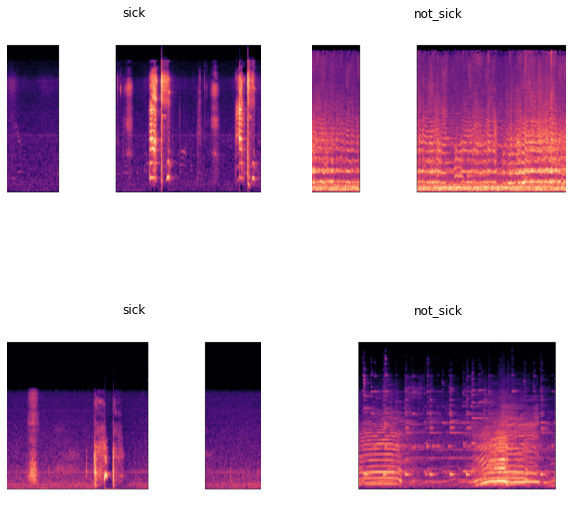

In [9]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(4):
  ax = plt.subplot(2, 2, i + 1)
  stats(image_batch[i].numpy())
  plt.imshow((image_batch[i].numpy()).astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

# model

### Feature extraction

In [10]:
IMG_SHAPE = (img_height, img_width, 3)
# base_model = tf.keras.applications.DenseNet201(include_top=False, 
#                                                weights='imagenet', 
#                                                input_shape=IMG_SHAPE,
#                                                classes=1)
base_model = tf.keras.applications.DenseNet121(include_top=False, 
                                               weights='imagenet', 
                                               input_shape=IMG_SHAPE,
                                               classes=1)
# )
# base_model = tf.keras.applications.ResNet50(include_top=False, 
#                                             weights='imagenet', 
#                                             input_shape=IMG_SHAPE,
#                                             classes=1)
# base_model = tf.keras.applications.Xception(include_top=False, 
#                                 weights='imagenet', 
#                                 input_shape=IMG_SHAPE,
#                                 classes=1)
base_model.trainable = False
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 480, 640, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 486, 646, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 240, 320, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 240, 320, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [11]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = tf.keras.applications.densenet.preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
# x = layers.Dropout(0.5)(x)
# x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 480, 640, 3)]     0         
_________________________________________________________________
tf_op_layer_truediv (TensorF [(None, 480, 640, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 480, 640, 3)]     0         
_________________________________________________________________
tf_op_layer_truediv_1 (Tenso [(None, 480, 640, 3)]     0         
_________________________________________________________________
densenet121 (Model)          (None, 15, 20, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0     

In [12]:
initial_epochs = 100

base_learning_rate = 0.0001
save_dir = './fine_tune_DenseNet121_mel/'
log_dir = save_dir + 'logs/'
checkpoint_dir = save_dir + 'checkpoint_Feature_extraction/'

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    base_learning_rate,
    decay_steps=steps_per_epoch*5,
    decay_rate=1,
    staircase=False)

optimizer = tf.keras.optimizers.Adam(lr_schedule)

callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
#         tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
        tf.keras.callbacks.TensorBoard(log_dir),
        tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir,
                                            monitor='val_accuracy',
                                             verbose=1,
                                             save_best_only=True,
                                            save_weights_only=True)
    ]

In [13]:
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.load_weights(checkpoint_dir)

history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    callbacks=callbacks)

Epoch 1/100
      1/Unknown - 9s 9s/step - loss: 0.4873 - accuracy: 1.0000WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.189305). Check your callbacks.
      2/Unknown - 9s 5s/step - loss: 0.4998 - accuracy: 0.8750WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.182673). Check your callbacks.
    929/Unknown - 138s 149ms/step - loss: 0.5911 - accuracy: 0.6714
Epoch 00001: val_accuracy improved from -inf to 0.73995, saving model to ./fine_tune_DenseNet121_mel/checkpoint_Feature_extraction/
929/929 [==============================] - 187s 201ms/step - loss: 0.5911 - accuracy: 0.6714 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
928/929 [============================>.] - ETA: 0s - loss: 0.5834 - accuracy: 0.6697
Epoch 00002: val_accuracy improved from 0.73995 to 0.74569, saving model to ./fine_tune_DenseNet121_mel/checkpoint_Feature_extraction/
929/929 [==============================] - 178s 191ms

In [14]:
model.load_weights(checkpoint_dir)
model.evaluate(test_ds)

413/413 [==============================] - 63s 152ms/step - loss: 0.5537 - accuracy: 0.7173


[0.553700057631832, 0.71731234]

### fine tuning

In [15]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

# # Fine-tune from this layer onwards
# fine_tune_at = 100

# # Freeze all the layers before the `fine_tune_at` layer
# for layer in base_model.layers[:fine_tune_at]:
#     layer.trainable =  False

Number of layers in the base model:  427


In [16]:
fine_tune_epochs = 100 + initial_epochs

checkpoint_dir = save_dir + 'checkpoint_fine-tuning_dataAgumation/'
callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10),
        tf.keras.callbacks.TensorBoard(log_dir),
        tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir+'model-{epoch:02d}-{val_loss:.4f}-{val_accuracy:.4f}.h5',
                                            monitor='val_accuracy',
                                             verbose=1,
#                                              save_best_only=True,
                                            save_weights_only=True)
    ]
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    base_learning_rate/3,
    decay_steps=steps_per_epoch*5,
    decay_rate=1,
    staircase=False)
optimizer = tf.keras.optimizers.Adam(lr_schedule)

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = optimizer,
              metrics=['accuracy'])
model.summary()
history_fine = model.fit(train_ds,
                         epochs=fine_tune_epochs,
#                          initial_epoch=history.epoch[-1],
                         validation_data=val_ds,
                         callbacks=callbacks)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 480, 640, 3)]     0         
_________________________________________________________________
tf_op_layer_truediv (TensorF [(None, 480, 640, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 480, 640, 3)]     0         
_________________________________________________________________
tf_op_layer_truediv_1 (Tenso [(None, 480, 640, 3)]     0         
_________________________________________________________________
densenet121 (Model)          (None, 15, 20, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0     

928/929 [============================>.] - ETA: 0s - loss: 0.0387 - accuracy: 0.9895
Epoch 00020: saving model to ./fine_tune_DenseNet121_mel/checkpoint_fine-tuning_dataAgumation/model-20-0.6379-0.8893.h5
929/929 [==============================] - 351s 377ms/step - loss: 0.0387 - accuracy: 0.9895 - val_loss: 0.6379 - val_accuracy: 0.8893
Epoch 21/200
928/929 [============================>.] - ETA: 0s - loss: 0.0405 - accuracy: 0.9898
Epoch 00021: saving model to ./fine_tune_DenseNet121_mel/checkpoint_fine-tuning_dataAgumation/model-21-0.5411-0.8950.h5
929/929 [==============================] - 348s 375ms/step - loss: 0.0405 - accuracy: 0.9898 - val_loss: 0.5411 - val_accuracy: 0.8950
Epoch 22/200
928/929 [============================>.] - ETA: 0s - loss: 0.0278 - accuracy: 0.9943
Epoch 00022: saving model to ./fine_tune_DenseNet121_mel/checkpoint_fine-tuning_dataAgumation/model-22-0.6003-0.8966.h5
929/929 [==============================] - 348s 375ms/step - loss: 0.0278 - accuracy: 0.9

In [17]:
model.evaluate(test_ds)

413/413 [==============================] - 63s 152ms/step - loss: 0.7357 - accuracy: 0.8783


[0.7356621188113859, 0.8783293]

In [18]:
model.load_weights('./fine_tune_DenseNet121_mel/checkpoint_fine-tuning_dataAgumation/model-19-0.6392-0.8999.h5')
model.evaluate(test_ds)

413/413 [==============================] - 63s 152ms/step - loss: 0.6052 - accuracy: 0.8856


[0.6051807731804922, 0.88559324]

In [19]:
model.load_weights('./fine_tune_DenseNet121_mel/checkpoint_fine-tuning_dataAgumation/model-05-0.3029-0.8843.h5')
model.evaluate(test_ds)

413/413 [==============================] - 62s 151ms/step - loss: 0.3121 - accuracy: 0.8838


[0.3120535554197452, 0.88377726]